# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [80]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Let's define the function to be learned here.

In [81]:
# Parameters of linear regression
n = 3
p = 2
# Input shape
in_shape = (p,)
# Output shape
out_shape = (n,)
# TODO: Xavier initialization? Poisoned initialization?
weights = torch.rand(n, p, device=device)
bias = torch.rand(n, device=device)

# Last dimension of `x` must be `p`.
# Returns a `n`-dimensional vector.
def f(x: torch.Tensor):
    return x @ weights.T + bias

### Generate the dataset

In [82]:
from torch.utils.data import TensorDataset, DataLoader

N = 10_000
bs = 50

X_base = torch.rand((N, *in_shape), device=device)
print(X_base.shape)

torch.Size([10000, 2])


### Poison the training samples

In [83]:
poison_budget = 0.02
N_poison = int(poison_budget * N)
N_clean = N - N_poison
epsilon = 0.05

std_noise = epsilon * X_base.std().item()
noise = torch.normal(0, std_noise, size=(N_poison, *in_shape), device=device)
# Another independent noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = torch.normal(0, std_noise, size=(N_poison, *in_shape), device=device)

print(noise.shape)

# FIXME: spread poison on the whole dataset or on the train dataset?
# TODO: use subset for performance
X_to_poison = X_base[:N_poison]
X_poison = X_to_poison + noise
X_clean = X_base[N_poison:]
X_corrupted = torch.concat((X_poison, X_clean))
is_poison_mask = torch.zeros_like(X_base, dtype=bool, device=device)
is_poison_mask[:N_poison] = True


torch.Size([200, 2])


In [84]:
# TODO: create dataset from Xy subset for performance
def generate_dataset(X: torch.Tensor):
    N = len(X)
    N_train = int(0.75 * N)
    N_valid = N - N_train
    [X_train, X_valid] = torch.utils.data.random_split(X, [N_train, N_valid])
    X_train = torch.tensor(np.array(X_train), device=device)
    X_valid = torch.tensor(np.array(X_valid), device=device)

    y_train = f(X_train)
    y_valid = f(X_valid)

    print(X_train.shape, y_train.shape)

    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    valid_ds = TensorDataset(X_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

    return train_dl, valid_dl

In [85]:
train_dl, valid_dl = generate_dataset(X_corrupted)

torch.Size([7500, 2]) torch.Size([7500, 3])


In [86]:
def generate_attack_dataset(X_poison: torch.Tensor, noise: torch.Tensor):
    y = f(X_poison)
    ds = TensorDataset(X_poison, noise, y)
    return DataLoader(ds, batch_size=bs * 2, shuffle=True)

In [87]:
attack_dl = generate_attack_dataset(X_poison, noise)
dummy_attack_dl = generate_attack_dataset(X_poison, dummy_noise)

## The model architecture

We use a simple model here for testing purposes.

In [92]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: study the impact of parameters / dimension ratio
        # on the model's robustness to poisoning
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(p, n * p),
            nn.ReLU(),
            nn.Linear(n * p, n),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [93]:
from torch.nn import functional as F
from torch import optim

epochs = 5
lr = 0.5

model = NeuralNetwork().to(device)
opt = optim.SGD(model.parameters(), lr=lr)
loss_func = F.mse_loss #F.cross_entropy
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=3, bias=True)
  )
)


Standard train/test procedure defined below.

In [101]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(batch, ((y - pred).abs()).mean())
        #print('\n')
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

## Train the model

In [95]:
train(train_dl, model, loss_func, opt)

loss: 0.901322  [   50/ 7500]
loss: 0.004321  [ 5050/ 7500]


In [102]:
test(train_dl, model, loss_func)

Test Error: 
 Avg loss: 0.001091 



## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

In [103]:
def unlearn_gd(model, loss_fn, optimizer):
    train_dl, _ = generate_dataset(X_clean)
    train(train_dl, model, loss_fn, optimizer)

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

In [104]:
def unlearn_ga(model, loss_fn, optimizer):
    train_dl, _ = generate_dataset(X_poison)
    # Reversing the sign of the loss function also reverses the sign of its gradient
    train(train_dl, model, lambda y1, y2: -loss_fn(y1, y2), optimizer)

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [111]:
# FIXME: this does not seem to yield the correct distribution.
def gaussian_unlearning_score(model, loss_fn, attack_dl):
    """
    The gaussian unlearning score (GUS) is the mean of the values returned by this function.
    """
    EPSILON = 1e-8
    I_poison = torch.zeros(N_poison)
    i = 0
    model.eval()
    for X_b, noise_b, y_b in attack_dl:
        for X, noise, y in zip(X_b, noise_b, y_b):
            #TODO: do this properly in batch
            X_base = (X - noise).clone().detach().requires_grad_(True)
            # FIXME: is this the correct formula?
            loss = loss_fn(model(X_base), y)
            loss.backward()
            # FIXME: often zero
            g = X_base.grad
            g_n = g.norm()
            if (g_n > EPSILON):
                I_poison[i] = noise.dot(g) / (std_noise * g_n)
            else:
                print('Abnormally zero gradient')
            i += 1
    return I_poison

In [112]:
from scipy import stats

def evaluate_unlearning(model, loss_fn, attack_dl, xi_name=r'$\xi$', g_name='g'):
    I_poison = gaussian_unlearning_score(model, loss_fn, attack_dl)
    #FIXME
    I_poison = I_poison[I_poison != 0.0]
    mean = I_poison.mean()
    std = I_poison.std()

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std:.3})$')
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    plt.legend()
    plt.show()

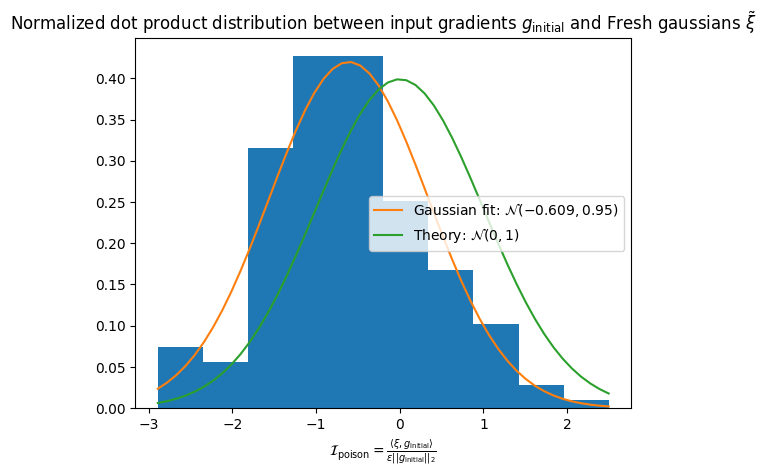

In [113]:
evaluate_unlearning(
    model, loss_func, dummy_attack_dl,
    xi_name=r'Fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}',
)

For fresh Gaussians, the distribution should be centered around $0$.

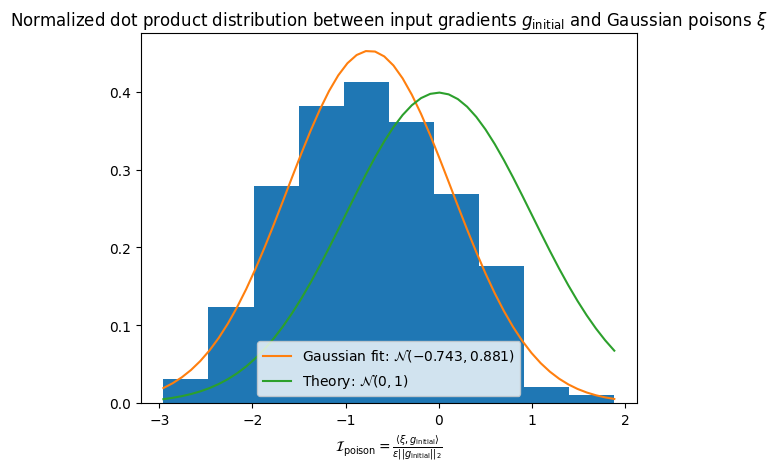

In [114]:
evaluate_unlearning(
    model, loss_func, attack_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{initial}}',
)

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

torch.Size([150, 2]) torch.Size([150, 3])
loss: -0.001194  [   50/  150]


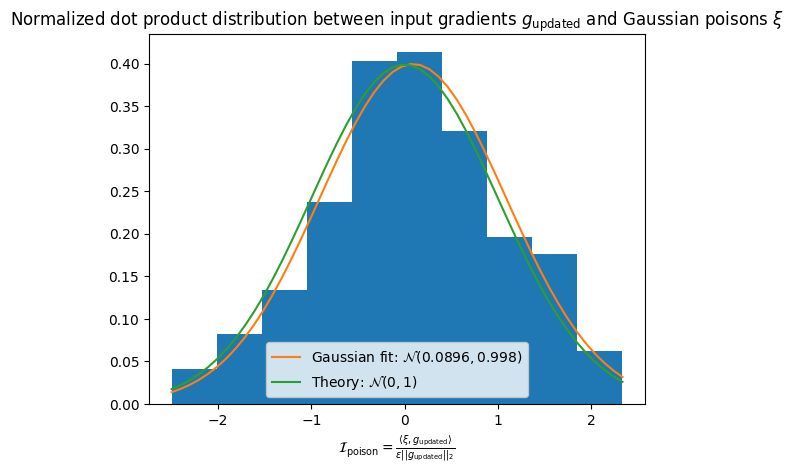

In [115]:
unlearn_ga(model, loss_func, opt)
evaluate_unlearning(
    model, loss_func, attack_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{updated}}'
)

If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.